# Image Reconstruction with a Neural Network

This notebook demonstrates how to use PyTorch to train a neural network for reconstructing occluded parts of images. The model predicts the mean RGB values of four subregions in the occluded region.

---

## Imports 

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.ndimage import label
import numpy as np
from find_black_rectangle import find_black_rectangle

## Preparing the Dataset

This dataset class loads paired masked and original images, detects the black square (occlusion), splits it into four subregions, and calculates the mean RGB values for each region.

In [2]:
class MaskedImageDataset(Dataset):
    """
    Custom PyTorch Dataset for handling masked and original image pairs.
    """
    def __init__(self, image_dir, grid_size=8, transform=None):
        """
        Args:
            image_dir (str): Directory containing original and masked image pairs.
            grid_size (int): Number of divisions for the grid (e.g., 8 for an 8x8 grid).
            transform (callable, optional): Transformation to apply to the images.
        """
        self.image_dir = image_dir
        self.image_names = [name for name in os.listdir(image_dir) if not name.endswith("_masked.jpg")]
        self.grid_size = grid_size
        self.transform = transform

    def __len__(self):
        """Returns the number of images in the dataset."""
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Loads and processes the masked and original images.

        Args:
            idx (int): Index of the image to fetch.

        Returns:
            torch.Tensor: Masked image tensor.
            torch.Tensor: Ground truth mean RGB values for each region.
        """
        # Load image paths
        original_name = self.image_names[idx]
        masked_name = original_name.replace(".jpg", "_masked.jpg")
        original_path = os.path.join(self.image_dir, original_name)
        masked_path = os.path.join(self.image_dir, masked_name)

        # Load images
        original_image = Image.open(original_path).convert("RGB")
        masked_image = Image.open(masked_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            original_image = self.transform(original_image)
            masked_image = self.transform(masked_image)

        # Convert images to NumPy arrays
        original_array = np.array(original_image.permute(1, 2, 0))
        mask_array = np.array(masked_image.permute(1, 2, 0))

        # Find the black rectangle's coordinates
        y_min, y_max, x_min, x_max = find_black_rectangle(mask_array)

        # Divide the rectangle into a grid of regions
        h_step = (y_max - y_min) // self.grid_size
        w_step = (x_max - x_min) // self.grid_size
        regions = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                y1 = y_min + i * h_step
                y2 = y1 + h_step
                x1 = x_min + j * w_step
                x2 = x1 + w_step
                regions.append((y1, y2, x1, x2))

        # Compute mean RGB for each region
        ground_truth = []
        for y1, y2, x1, x2 in regions:
            region_pixels = original_array[y1:y2, x1:x2, :]
            ground_truth.append(region_pixels.mean(axis=(0, 1)))

        # Convert the ground truth to a tensor
        ground_truth = torch.tensor(np.array(ground_truth)).float()

        return masked_image, ground_truth

## Data Transformation and Loader

The images are normalized, and a DataLoader is prepared for efficient data processing.

In [3]:
# Base directory for the dataset
base_dir = os.path.join("..", "Dataset")

# Directories for train, validation, and test sets
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Grid size for splitting the black rectangle
grid_size = 4

# Datasets and Dataloaders
train_dataset = MaskedImageDataset(image_dir=train_dir, transform=transform, grid_size=grid_size)
val_dataset = MaskedImageDataset(image_dir=val_dir, transform=transform, grid_size=grid_size)
test_dataset = MaskedImageDataset(image_dir=test_dir, transform=transform, grid_size=grid_size)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Building the Neural Network

We define a fully connected neural network to predict the mean RGB values of four regions.

In [4]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ColorPredictor(nn.Module):
    def __init__(self, grid_size):
        super(ColorPredictor, self).__init__()
        self.grid_size = grid_size

        # Convolutional and pooling layers (deeper with more filters)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 224x224 -> 224x224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 224x224 -> 224x224
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224x224 -> 112x112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 112x112 -> 112x112
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 112x112 -> 112x112
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112 -> 56x56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 56x56 -> 56x56
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # 56x56 -> 56x56
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 56x56 -> 28x28
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 4096),  # Output size of the final conv block
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.2),  # Balanced regularization
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, grid_size**2 * 3),  # Output: grid_size^2 regions × 3 RGB values
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

Using device: cuda


## Training the Neural Network

The model is trained for 10 epochs using the Mean Squared Error (MSE) loss function.

Epoch 1/20 - Train Loss: 0.0919, Val Loss: 0.0455
Epoch 2/20 - Train Loss: 0.0581, Val Loss: 0.0529
Epoch 3/20 - Train Loss: 0.0436, Val Loss: 0.0309
Epoch 4/20 - Train Loss: 0.0374, Val Loss: 0.0314
Epoch 5/20 - Train Loss: 0.0343, Val Loss: 0.0277
Epoch 6/20 - Train Loss: 0.0309, Val Loss: 0.0376
Epoch 7/20 - Train Loss: 0.0274, Val Loss: 0.0259
Epoch 8/20 - Train Loss: 0.0246, Val Loss: 0.0275
Epoch 9/20 - Train Loss: 0.0220, Val Loss: 0.0333
Epoch 10/20 - Train Loss: 0.0203, Val Loss: 0.0290
Epoch 11/20 - Train Loss: 0.0190, Val Loss: 0.0256
Epoch 12/20 - Train Loss: 0.0173, Val Loss: 0.0263
Epoch 13/20 - Train Loss: 0.0163, Val Loss: 0.0292
Epoch 14/20 - Train Loss: 0.0152, Val Loss: 0.0296
Epoch 15/20 - Train Loss: 0.0145, Val Loss: 0.0416
Epoch 16/20 - Train Loss: 0.0135, Val Loss: 0.0360
Epoch 17/20 - Train Loss: 0.0128, Val Loss: 0.0415
Epoch 18/20 - Train Loss: 0.0122, Val Loss: 0.0417
Epoch 19/20 - Train Loss: 0.0115, Val Loss: 0.0365
Epoch 20/20 - Train Loss: 0.0110, Val Lo

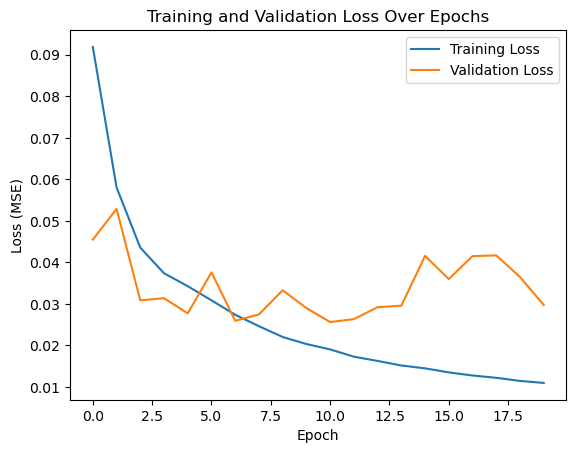

In [5]:
# Define the model, criterion, and optimizer
model = ColorPredictor(grid_size=grid_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20
train_losses = []
val_losses = []  # For storing validation losses

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for masked_images, ground_truths in train_dataloader:
        optimizer.zero_grad()
        
        # Move data to GPU
        masked_images = masked_images.to(device)
        ground_truths = ground_truths.to(device)
        
        # Forward pass
        outputs = model(masked_images)  # Shape: [batch_size, grid_size**2 * 3]
        # print(f"Outputs shape: {outputs.shape}")  # Debugging
        # print(f"Ground truths shape: {ground_truths.view(-1, grid_size**2 * 3).shape}")  # Debugging
    
        # Compute loss
        loss = criterion(outputs, ground_truths.view(-1, grid_size**2 * 3))  # Reshape ground_truths to match outputs
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_ground_truths in val_dataloader:
            
            # Move validation data to GPU
            val_images = val_images.to(device)
            val_ground_truths = val_ground_truths.to(device)
            
            val_outputs = model(val_images)  # Forward pass
            # print(f"Validation outputs shape: {val_outputs.shape}")  # Debugging
            # print(f"Validation ground truths shape: {val_ground_truths.view(-1, grid_size**2 * 3).shape}")  # Debugging
            
            # Compute validation loss
            loss = criterion(val_outputs, val_ground_truths.view(-1, grid_size**2 * 3))  # Reshape ground_truths
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    # Print losses for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()



In [6]:
# Function to overlay predictions on the black rectangle of the original masked image
def overlay_predictions_on_black_rectangle(masked_image, predictions, grid_size):
    """Overlay the predicted RGB regions on the black rectangle of the original masked image."""
    # Normalize masked_image to [0, 1] for find_black_rectangle
    masked_image_normalized = masked_image / 255.0 if masked_image.max() > 1 else masked_image
    black_box_coords = find_black_rectangle(masked_image_normalized)
    y_min, y_max, x_min, x_max = black_box_coords

    # Calculate the height and width of each region
    region_height = (y_max - y_min) // grid_size
    region_width = (x_max - x_min) // grid_size

    # Convert tensor to numpy if needed
    if isinstance(masked_image, torch.Tensor):
        masked_image = masked_image.permute(1, 2, 0).cpu().numpy()

    # Overlay the predicted RGB colors in the corresponding regions
    for i in range(grid_size):
        for j in range(grid_size):
            y1 = y_min + i * region_height
            y2 = y1 + region_height
            x1 = x_min + j * region_width
            x2 = x1 + region_width
            region_idx = i * grid_size + j  # Calculate the region index
            predicted_color = (predictions[region_idx] * 255.0).astype(np.uint8)  # Scale predictions to [0, 255]
            masked_image[y1:y2, x1:x2, :] = predicted_color  # Overlay predicted RGB values

    return masked_image

## Testing the Model

The test dataset is used to evaluate the final model and compute MSE and MAE metrics.

In [7]:
# import torch
# import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# 
# # Ensure the model is on the correct device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()
# 
# # Metrics for mean color vs. output color
# test_mse, test_mae = 0.0, 0.0
# mse_list = []
# mae_list = []
# 
# # Un-normalize images for pixel-to-pixel comparison
# unnormalized_reconstructed_images = []
# unnormalized_test_images = []
# 
# with torch.no_grad():
#     for masked_images, ground_truths in test_dataloader:
#         # Move data to the correct device
#         masked_images = masked_images.to(device)
#         ground_truths = ground_truths.to(device)
# 
#         # Flatten ground_truths to match the model's output
#         batch_size = masked_images.size(0)
#         ground_truths = ground_truths.view(batch_size, -1)
# 
#         # Forward pass
#         outputs = model(masked_images)
# 
#         # Convert tensors to NumPy arrays for metric computation
#         ground_truths_np = ground_truths.cpu().numpy()
#         outputs_np = outputs.cpu().numpy()
# 
#         # Ensure shapes match
#         assert ground_truths_np.shape == outputs_np.shape, f"Shape mismatch: {ground_truths_np.shape} vs {outputs_np.shape}"
# 
#         # Calculate grid-based metrics
#         test_mse += mean_squared_error(ground_truths_np, outputs_np)
#         test_mae += mean_absolute_error(ground_truths_np, outputs_np)
# 
#         # Reconstruct full images for pixel-to-pixel evaluation
#         for i in range(batch_size):
#             reconstructed = outputs_np[i].reshape(grid_size, grid_size, 3) * 255.0  # Rescale to [0, 255]
#             original = ground_truths_np[i].reshape(grid_size, grid_size, 3) * 255.0  # Rescale to [0, 255]
#             unnormalized_reconstructed_images.append(np.clip(reconstructed, 0, 255))
#             unnormalized_test_images.append(np.clip(original, 0, 255))
# 
# # Pixel-level evaluation
# for reconstructed, original in zip(unnormalized_reconstructed_images, unnormalized_test_images):
#     mse_list.append(mean_squared_error(original.flatten(), reconstructed.flatten()))
#     mae_list.append(mean_absolute_error(original.flatten(), reconstructed.flatten()))
# 
# average_pixel_mse = np.mean(mse_list)
# average_pixel_mae = np.mean(mae_list)
# 
# # Average the grid-based metrics
# test_mse /= len(test_dataloader)
# test_mae /= len(test_dataloader)
# 
# # Print combined results
# print("\nGrid-Based Metrics (Mean Color vs. Output Color):")
# print(f"  Test Grid MSE: {test_mse:.4f}")
# print(f"  Test Grid MAE: {test_mae:.4f}")
# 
# print("\nPixel-Based Metrics (Original vs. Reconstructed Images):")
# print(f"  Pixel MSE: {average_pixel_mse:.2f}")
# print(f"  Pixel MAE: {average_pixel_mae:.2f}")
# 
# # for debug 
# print(original)
# print("________________________________")
# print(reconstructed)
# print("-----------------------------------")
# print(mse_list)

import os
import torch
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the dataset directory relative to the script
dataset_dir = os.path.join("..", "Dataset", "test")

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Metrics for mean color vs. output color
test_mse, test_mae = 0.0, 0.0
mse_list = []
mae_list = []

# Evaluation loop
with torch.no_grad():
    for idx, (masked_images, ground_truths) in enumerate(test_dataloader):
        # Move data to the correct device
        masked_images = masked_images.to(device)
        ground_truths = ground_truths.to(device)

        # Flatten ground_truths to match the model's output
        batch_size = masked_images.size(0)
        ground_truths = ground_truths.view(batch_size, -1)

        # Forward pass
        outputs = model(masked_images)

        # Convert tensors to NumPy arrays
        ground_truths_np = ground_truths.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        # Ensure shapes match
        assert ground_truths_np.shape == outputs_np.shape, \
            f"Shape mismatch: {ground_truths_np.shape} vs {outputs_np.shape}"

        # Calculate grid-based metrics
        batch_mse = mean_squared_error(ground_truths_np, outputs_np)
        batch_mae = mean_absolute_error(ground_truths_np, outputs_np)
        test_mse += batch_mse
        test_mae += batch_mae


        for i in range(batch_size):
            # Masked image for overlay
            masked_image = (masked_images[i] * 255.0).permute(1, 2, 0).cpu().numpy().astype(np.float32)

            # Get the corresponding original image path
            masked_image_path = test_dataloader.dataset.image_names[idx * batch_size + i]
            original_image_name = masked_image_path.replace("_masked", "")
            original_image_full_path = os.path.join(dataset_dir, original_image_name)

            # Load original image
            original_image = Image.open(original_image_full_path).convert("RGB")
            original_image = np.array(original_image).astype(np.float32)

            # Overlay predictions onto the masked image
            predictions = outputs_np[i].reshape(-1, 3)  # Reshape predictions to match grid format
            overlay_image = overlay_predictions_on_black_rectangle(masked_image.copy(), predictions, grid_size)

            # Ensure shapes match for comparison
            assert original_image.shape == overlay_image.shape, \
                f"Shape mismatch: {original_image.shape} vs {overlay_image.shape}"

            # Compute pixel-level metrics
            mse_list.append(mean_squared_error(original_image.flatten(), overlay_image.flatten()))
            mae_list.append(mean_absolute_error(original_image.flatten(), overlay_image.flatten()))

        

# Pixel-level evaluation
average_pixel_mse = np.mean(mse_list)
average_pixel_mae = np.mean(mae_list)

# Average the grid-based metrics
test_mse /= len(test_dataloader)
test_mae /= len(test_dataloader)

# Print combined results
print("\nGrid-Based Metrics (Mean Color vs. Output Color):")
print(f"  Test Grid MSE: {test_mse:.4f}")
print(f"  Test Grid MAE: {test_mae:.4f}")

print("\nPixel-Based Metrics (Original vs. Overlay Images):")
print(f"  Pixel MSE: {average_pixel_mse:.2f}")
print(f"  Pixel MAE: {average_pixel_mae:.2f}")




Grid-Based Metrics (Mean Color vs. Output Color):
  Test Grid MSE: 0.0265
  Test Grid MAE: 0.1194

Pixel-Based Metrics (Original vs. Overlay Images):
  Pixel MSE: 399.70
  Pixel MAE: 3.65


## Final Visualization with Refrence_Images

We generate reconstructed images and display them alongside the masked images.

Using device: cuda


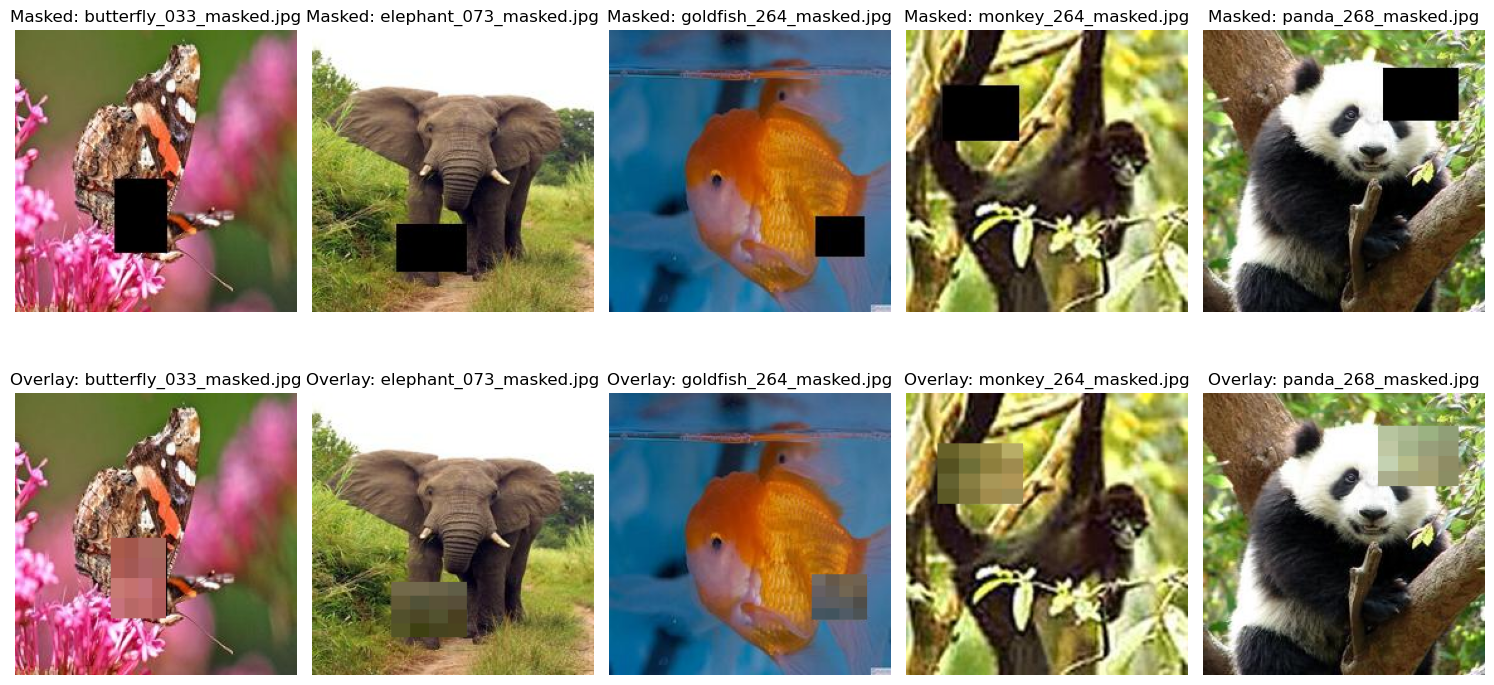

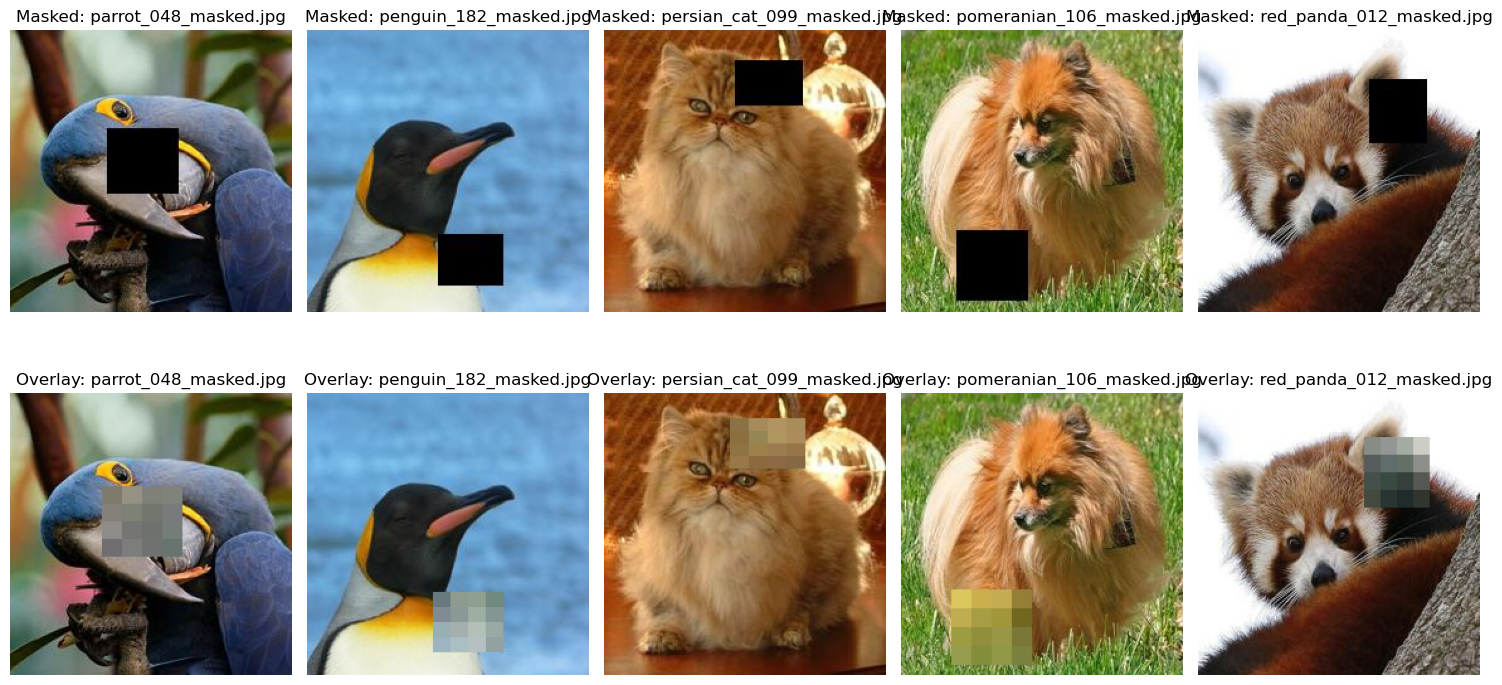

<Figure size 640x480 with 0 Axes>

In [10]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Path to the Reference_Images directory
reference_images_dir = os.path.join("..", "Reference_Images")
masked_image_files = sorted(os.listdir(reference_images_dir))

# Load and process masked images from the directory
masked_images = []
for file_name in masked_image_files:
    image_path = os.path.join(reference_images_dir, file_name)
    masked_image = Image.open(image_path).convert("RGB")  # Open image in RGB format
    masked_images.append(transform(masked_image))  # Apply transformations (e.g., ToTensor)

# Stack into a batch and move to the device
masked_images = torch.stack(masked_images).to(device)  # Shape: [batch_size, channels, height, width]

# Ensure the model is on the correct device
model.to(device)
model.eval()

# Generate reconstructed images using the trained model
with torch.no_grad():
    generated_images = model(masked_images)  # Model output
    generated_images = generated_images.cpu()  # Move to CPU for further processing

# Reshape generated_images to [batch_size, grid_size**2, 3]
generated_images = generated_images.view(-1, grid_size**2, 3)  # Dynamic shape based on grid_size

# # Function to overlay predictions on the black rectangle of the original masked image
# def overlay_predictions_on_black_rectangle(masked_image, predictions, grid_size):
#     """Overlay the predicted RGB regions on the black rectangle of the original masked image."""
#     # Normalize masked_image to [0, 1] for find_black_rectangle
#     masked_image_normalized = masked_image / 255.0 if masked_image.max() > 1 else masked_image
#     black_box_coords = find_black_rectangle(masked_image_normalized)
#     y_min, y_max, x_min, x_max = black_box_coords
# 
#     # Calculate the height and width of each region
#     region_height = (y_max - y_min) // grid_size
#     region_width = (x_max - x_min) // grid_size
# 
#     # Convert tensor to numpy if needed
#     if isinstance(masked_image, torch.Tensor):
#         masked_image = masked_image.permute(1, 2, 0).cpu().numpy()
# 
#     # Overlay the predicted RGB colors in the corresponding regions
#     for i in range(grid_size):
#         for j in range(grid_size):
#             y1 = y_min + i * region_height
#             y2 = y1 + region_height
#             x1 = x_min + j * region_width
#             x2 = x1 + region_width
#             region_idx = i * grid_size + j  # Calculate the region index
#             predicted_color = (predictions[region_idx] * 255.0).astype(np.uint8)  # Scale predictions to [0, 255]
#             masked_image[y1:y2, x1:x2, :] = predicted_color  # Overlay predicted RGB values
# 
#     return masked_image

# Visualization with a 5x6 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns for 10 images

for i, file_name in enumerate(masked_image_files):
    try:
        # Convert tensors to [height, width, channels] for imshow
        masked_image = (masked_images[i] * 255.0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)  # Original masked image
        overlay_image = overlay_predictions_on_black_rectangle(
            masked_image.copy(), np.clip(generated_images[i].cpu().numpy(), 0, 1), grid_size
        )  # Overlay predictions on the black rectangle
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        continue

    # Row 1: Original masked images
    axs[0, i % 5].imshow(masked_image)
    axs[0, i % 5].axis("off")
    axs[0, i % 5].set_title(f"Masked: {file_name}")

    # Row 2: Overlays on original images
    axs[1, i % 5].imshow(overlay_image)
    axs[1, i % 5].axis("off")
    axs[1, i % 5].set_title(f"Overlay: {file_name}")

    # If it's the last image in a row of 5, finalize the current grid and start a new one
    if (i + 1) % 5 == 0 or i == len(masked_image_files) - 1:
        plt.tight_layout()
        plt.show()

        if i != len(masked_image_files) - 1:  # If not the last set, create a new grid
            fig, axs = plt.subplots(2, 5, figsize=(15, 8))

# Final adjustment and display
fig.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()

# Saving the Trained Model

After training, we need to save the model's parameters so that it can be reused for inference or further training. 
The following code saves the model's state dictionary to a file.

In [9]:
# Define the save path
model_save_path = os.path.join("..", "saved_models", "Neural_network", "NeuralNetwork_ImageReconstruction_testing.pth")

# Ensure the directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save only the model's state dictionary
try:
    torch.save(model.state_dict(), model_save_path)  # Save only the weights
    print(f"Model successfully saved to {model_save_path}")
except Exception as e:
    print(f"Error saving the model: {e}")

Model successfully saved to ..\saved_models\Neural_network\NeuralNetwork_ImageReconstruction_testing.pth
